In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

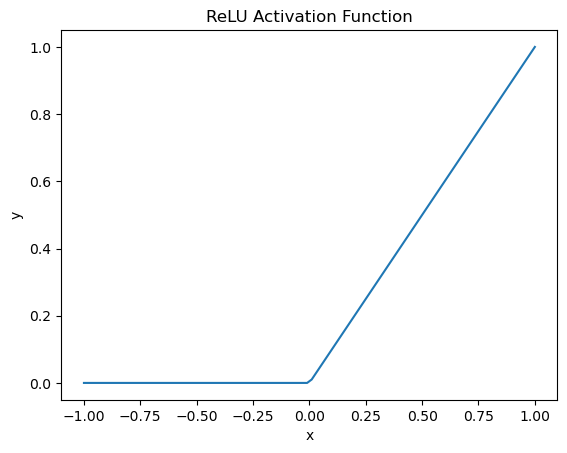

In [2]:
x = np.linspace(-1, 1, 100)
y = np.maximum(0, x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("ReLU Activation Function")
plt.savefig("Figure_7.png")

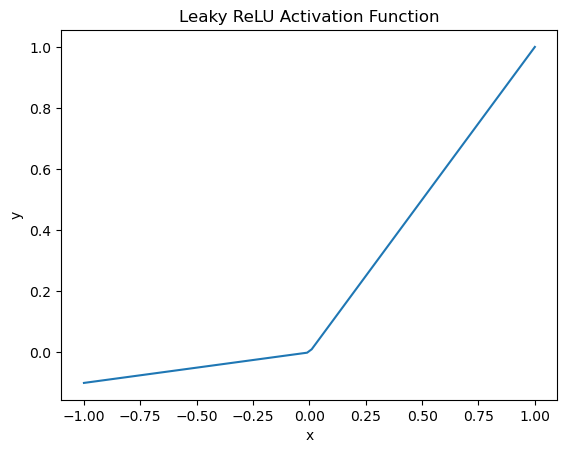

In [11]:
x = np.linspace(-1, 1, 100)
y = np.maximum(0.1*x, x)

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Leaky ReLU Activation Function")
plt.savefig("Figure_8.png")

In [2]:
from torchvision.datasets import MNIST

In [3]:
# init with the 'data' dir
mnist_trainset = MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = MNIST(root='./data', train=False, download=True, transform=None)

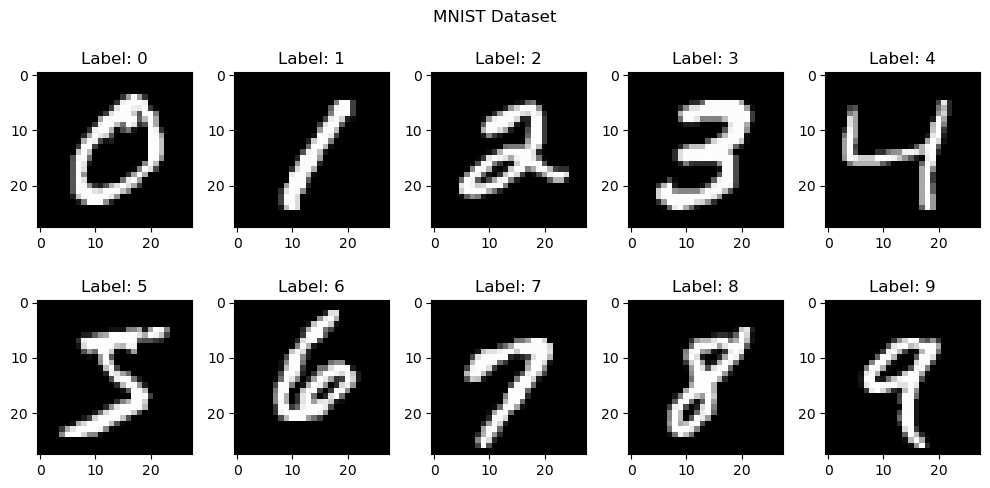

In [5]:
xs = [None]*10
idxs = np.arange(10)
for i, (x, y) in enumerate(mnist_trainset):
    x = np.array(x)

    if np.isin(y, idxs):
        xs[y] = x
        idxs = np.delete(idxs, np.where(idxs == y))

    if len(idxs) == 0:
        break
xs = np.array(xs)

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(xs[i], cmap='gray')
    ax.set_title(f"Label: {i}")

plt.suptitle("MNIST Dataset")
plt.tight_layout()
plt.savefig("Figure_9.png")

In [4]:
train_x = mnist_trainset.data.numpy() / 255.0
train_y = mnist_trainset.targets.numpy()
test_x = mnist_testset.data.numpy() / 255.0
test_y = mnist_testset.targets.numpy()

In [8]:
print(train_x.min(), train_x.max(), train_x.mean())
print(train_y.min(), train_y.max(), train_y.mean())
print(test_x.min(), test_x.max(), test_x.mean())
print(test_y.min(), test_y.max(), test_y.mean())

0.0 1.0 0.1306604762738429
0 9 4.4539333333333335
0.0 1.0 0.13251460584233699
0 9 4.4434


In [9]:
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28) float64
(60000,) int64
(10000, 28, 28) float64
(10000,) int64


In [10]:
train_idxs = np.argsort(train_y)
train_x = train_x[train_idxs]
train_y = train_y[train_idxs]

idxs = np.argsort(test_y)
test_x = test_x[idxs]
test_y = test_y[idxs]

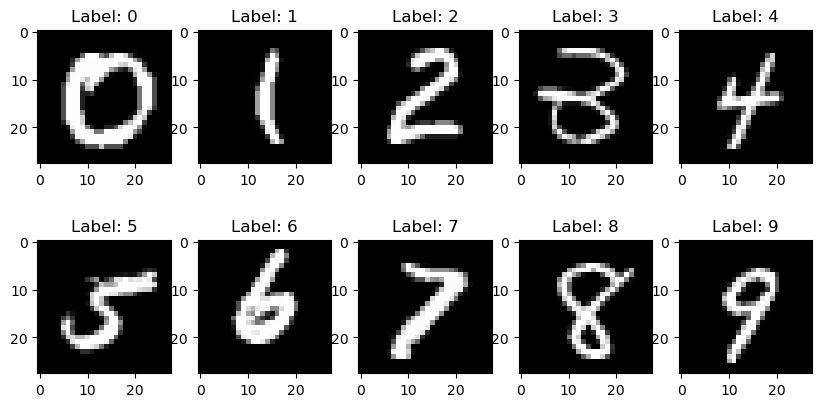

In [76]:
# Plot samples by picking random indices from each class
from IPython.display import clear_output
import time

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for j in range(20):
    clear_output(wait=True)
    for i, ax in enumerate(axs.flatten()):
        class_idxs = np.where(train_y == i)[0]
        idx = np.random.choice(class_idxs)
        ax.imshow(train_x[idx], cmap='gray')
        ax.set_title(f"Label: {train_y[idx]}")
    plt.show()
    time.sleep(1)
    clear_output(wait=True)
    plt.show()


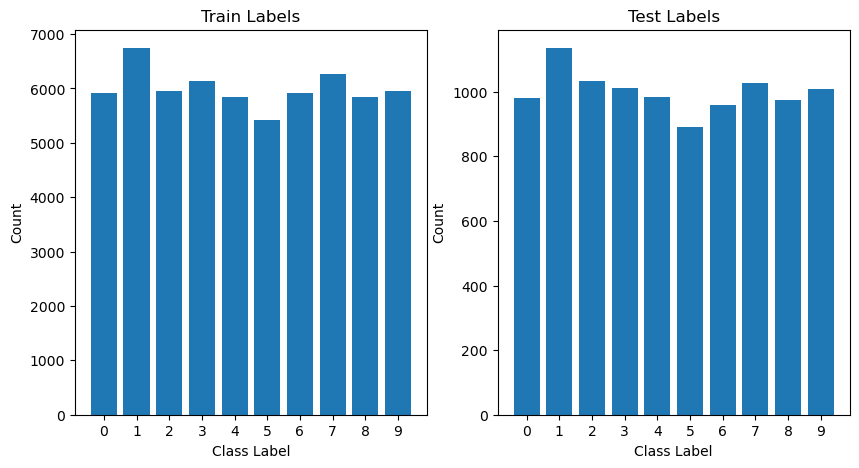

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
train_counts = np.unique(train_y, return_counts=True)
axs[0].bar(train_counts[0], train_counts[1])
axs[0].set_xticks(np.arange(10))
axs[0].set_xlabel("Class Label")
axs[0].set_ylabel("Count")
axs[0].set_title("Train Labels")

test_counts = np.unique(test_y, return_counts=True)
axs[1].bar(test_counts[0], test_counts[1])
axs[1].set_xticks(np.arange(10))
axs[1].set_xlabel("Class Label")
axs[1].set_ylabel("Count")
axs[1].set_title("Test Labels")

plt.savefig("Figure_10.png")

In [32]:
class DNN():
    def __init__(self, layers=4, hidden_dim=128, lr=0.001):
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.lr = lr

        self.params = {}
        self.grads = {}
        self.cache = {}
        
        self._init_params()

    def _init_params(self):
        self.params['W1'] = np.random.randn(784, self.hidden_dim) * 0.01
        self.params['b1'] = np.zeros(self.hidden_dim)
        for i in range(2, self.layers):
            self.params[f'W{i}'] = np.random.randn(self.hidden_dim, self.hidden_dim) * 0.01
            self.params[f'b{i}'] = np.zeros(self.hidden_dim)
        self.params[f'W{self.layers}'] = np.random.randn(self.hidden_dim, 10) * 0.01
        self.params[f'b{self.layers}'] = np.zeros(10)

    def _relu(self, x):
        return np.maximum(0, x)

    def _softmax(self, x):
        exp = np.exp(x - np.max(x)) # for numerical stability
        denom = np.sum(exp, axis=1, keepdims=True)
        
        return exp / denom

    def _cross_entropy(self, y, y_hat):
        return -np.sum(y * np.log(y_hat + 1e-7)) / y.shape[0]

    def _forward(self, x):
        self.cache['A0'] = x
        for i in range(1, self.layers):
            self.cache[f'Z{i}'] = np.dot(self.cache[f'A{i-1}'], self.params[f'W{i}']) + self.params[f'b{i}']
            self.cache[f'A{i}'] = self._relu(self.cache[f'Z{i}'])
        self.cache[f'Z{self.layers}'] = np.dot(self.cache[f'A{self.layers-1}'], self.params[f'W{self.layers}']) + self.params[f'b{self.layers}']
        self.cache[f'A{self.layers}'] = self._softmax(self.cache[f'Z{self.layers}'])
    
        return self.cache[f'A{self.layers}']

    def _backward(self, y):
        self.grads[f'dZ{self.layers}'] = self.cache[f'A{self.layers}'] - y
        self.grads[f'dW{self.layers}'] = np.dot(self.cache[f'A{self.layers-1}'].T, self.grads[f'dZ{self.layers}'])
        self.grads[f'db{self.layers}'] = np.sum(self.grads[f'dZ{self.layers}'], axis=0)
        for i in range(self.layers-1, 0, -1):
            self.grads[f'dA{i}'] = np.dot(self.grads[f'dZ{i+1}'], self.params[f'W{i+1}'].T)
            self.grads[f'dZ{i}'] = self.grads[f'dA{i}'] * (self.cache[f'Z{i}'] > 0).astype(np.float32)
            self.grads[f'dW{i}'] = np.dot(self.cache[f'A{i-1}'].T, self.grads[f'dZ{i}'])
            self.grads[f'db{i}'] = np.sum(self.grads[f'dZ{i}'], axis=0)

    def _update(self):
        for i in range(1, self.layers+1):
            self.params[f'W{i}'] -= self.lr * self.grads[f'dW{i}']
            self.params[f'b{i}'] -= self.lr * self.grads[f'db{i}']

    def step(self, x, y):
        y_hat = self._forward(x)
        loss = self._cross_entropy(y, y_hat)
        self._backward(y)
        self._update()

        return loss

    def predict(self, x):
        return np.argmax(self._forward(x), axis=1)

    def evaluate(self, x, y):
        y_hat = self._forward(x)
        loss = self._cross_entropy(y, y_hat)
        accuracy = np.mean(np.argmax(y_hat, axis=1) == np.argmax(y, axis=1))

        return loss, accuracy


In [36]:
dnn = DNN(layers=4, hidden_dim=128, lr=0.001)

In [37]:
batch_size = 600

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(100):
    rand_idxs = np.random.permutation(train_x.shape[0])

    for i in range(0, train_x.shape[0], batch_size):
        batch_idxs = rand_idxs[i:i+batch_size]
        x = train_x[batch_idxs].reshape(batch_size, -1) # reshape H x W to one dimension
        y = np.eye(10)[train_y[batch_idxs]] # one hot encoding
        loss = dnn.step(x, y)

    train_loss, train_accuracy = dnn.evaluate(train_x.reshape(train_x.shape[0], -1), np.eye(10)[train_y])
    test_loss, test_accuracy = dnn.evaluate(test_x.reshape(test_x.shape[0], -1), np.eye(10)[test_y])

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch: {epoch+1} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_accuracy:.5f}")
    print(f"Epoch: {epoch+1} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.5f}")

Epoch: 1 | Train Loss: 2.30115 | Train Accuracy: 0.11237
Epoch: 1 | Test Loss: 2.30108 | Test Accuracy: 0.11350
Epoch: 2 | Train Loss: 2.30041 | Train Accuracy: 0.11237
Epoch: 2 | Test Loss: 2.30028 | Test Accuracy: 0.11350
Epoch: 3 | Train Loss: 1.83498 | Train Accuracy: 0.22303
Epoch: 3 | Test Loss: 1.84331 | Test Accuracy: 0.22330
Epoch: 4 | Train Loss: 0.83787 | Train Accuracy: 0.70268
Epoch: 4 | Test Loss: 0.83364 | Test Accuracy: 0.70750
Epoch: 5 | Train Loss: 0.30665 | Train Accuracy: 0.91808
Epoch: 5 | Test Loss: 0.30524 | Test Accuracy: 0.91910
Epoch: 6 | Train Loss: 0.18361 | Train Accuracy: 0.94665
Epoch: 6 | Test Loss: 0.19075 | Test Accuracy: 0.94580
Epoch: 7 | Train Loss: 0.15906 | Train Accuracy: 0.95483
Epoch: 7 | Test Loss: 0.17902 | Test Accuracy: 0.94850
Epoch: 8 | Train Loss: 0.16045 | Train Accuracy: 0.95220
Epoch: 8 | Test Loss: 0.18192 | Test Accuracy: 0.94610
Epoch: 9 | Train Loss: 0.10788 | Train Accuracy: 0.96775
Epoch: 9 | Test Loss: 0.13601 | Test Accuracy: 

/var/folders/ff/8y1xxxcn7674c5yhwdbprh280000gn/T/ipykernel_64174/1825520834.py:29: RuntimeWarning: invalid value encountered in divide
  return exp / denom


Epoch: 14 | Train Loss: nan | Train Accuracy: 0.09872
Epoch: 14 | Test Loss: nan | Test Accuracy: 0.09800
Epoch: 15 | Train Loss: nan | Train Accuracy: 0.09872
Epoch: 15 | Test Loss: nan | Test Accuracy: 0.09800
Epoch: 16 | Train Loss: nan | Train Accuracy: 0.09872
Epoch: 16 | Test Loss: nan | Test Accuracy: 0.09800
Epoch: 17 | Train Loss: nan | Train Accuracy: 0.09872
Epoch: 17 | Test Loss: nan | Test Accuracy: 0.09800
Epoch: 18 | Train Loss: nan | Train Accuracy: 0.09872
Epoch: 18 | Test Loss: nan | Test Accuracy: 0.09800


KeyboardInterrupt: 

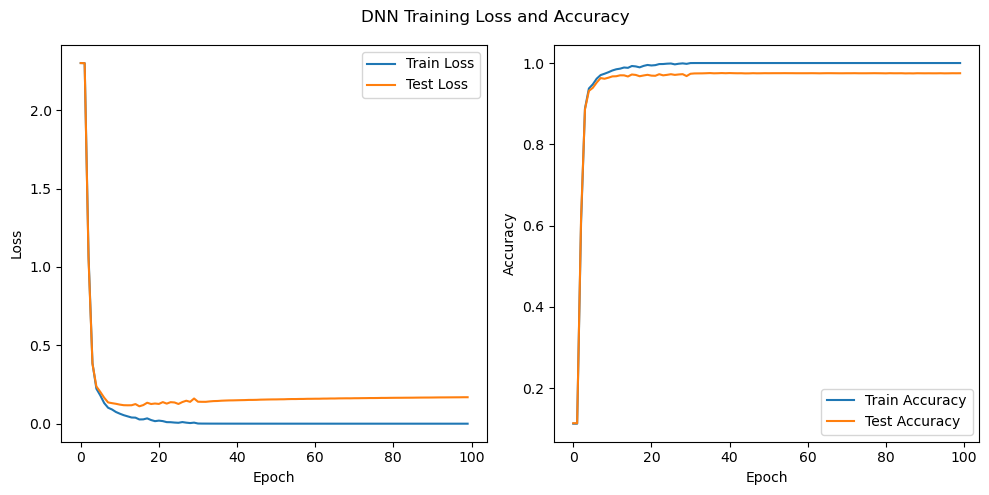

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(test_losses, label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(train_accuracies, label="Train Accuracy")
axs[1].plot(test_accuracies, label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.suptitle("DNN Training Loss and Accuracy batch_size=60")

plt.tight_layout()
plt.savefig("Figure_11.png")
plt.show()

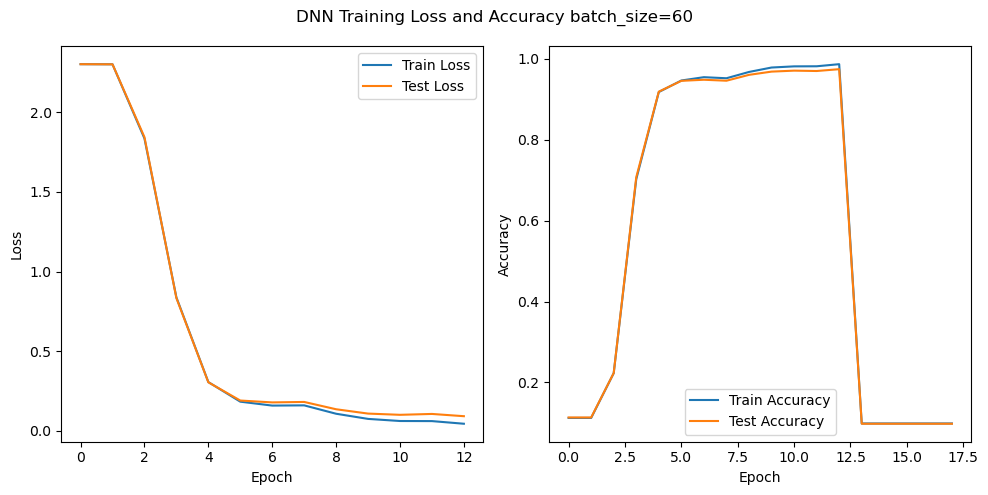

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(test_losses, label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(train_accuracies, label="Train Accuracy")
axs[1].plot(test_accuracies, label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.suptitle("DNN Training Loss and Accuracy batch_size=60")

plt.tight_layout()
plt.savefig("Figure_12.png")
plt.show()